## D212 Data Mining 2 PA 3
##### Submitted By Edwin Perry
### Table of Contents
<ol>
    <li><a href="#A">Research Question</a></li>
    <li><a href="#B">Technique Justification</a></li>
    <li><a href="#C">Data Preparation</a></li>
    <li><a href="#D">Analysis</a></li>
    <li><a href="#E">Data Summary and Implications</a></li>
    <li><a href="#F">Sources</a></li>
</ol>
<h4 id="A">Research Question</h4>
<h5>Question</h5>
<p>The research question I decided to address in this report is "Can I accurately forecast company revenue using time series analysis in the WGU provided telecommunications dataset?"</p>
<h5>Objectives/Goals</h5>
<p>The goal for this analysis is to accurately forecast the company revenue based on the data included within the csv file. As I do not have distinct datasets provided, showing progression over time, I will instead elect to split my dataset into 2 datasets: a training set consisting of 80% of the dataset, and a test set containing 20% of the dataset. The training set will be used to create the ARIMA time series model, then test set will be used to evaluate the performance. The goal of this is to generate a model that can accurately predict customer revenue</p>
<h4 id="4">Assumption</h4>
<h5>Time Series Assumption</h5>
<p>There are a number of assumptions that must be made for a time series analysis to be a valid analytical practice:
<ul>
<li>The data provided must be stationary. That is, the data cannot be influenced by trends or seasonality, and the mean and variance stay approximately constant over time</li>
<li>The data provided must not suffer from autocorrelation. This means that the entries in earlier rows or times cannot influence the results from future times/rows</li>
</ul>
</p>
<h4 id="C">Data Preparation</h4>
<h5>Time Series Visualization</h5>
<p>Before we begin the analysis, it is important to understand the underlying data. As such, we will start by visualizing how the data changed over time</p>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv('./s8dj4edjf84hd8fcvn3d/teleco_time_series .csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


<p>Here, we can see that the dataset consists of 2 columns: a day index that stores the count of days that have passed as an integer, and a revenue column that stores the revenue generated in a float. Now that we know the structure of the data source, we can create the graph</p>

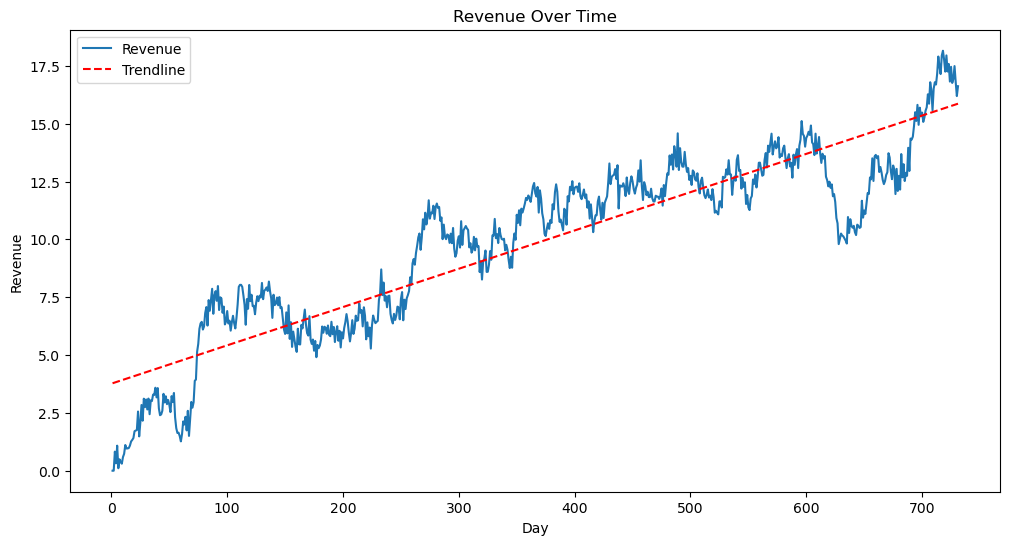

In [11]:
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue'], label='Revenue')

# Adding a trendline
z = np.polyfit(df['Day'], df['Revenue'], 1)
p = np.poly1d(z)
plt.plot(df['Day'], p(df['Day']), "r--", label='Trendline')

# Adding labels and title
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.title('Revenue Over Time')
plt.legend()
plt.show()


<h5>Time Step Formatting</h5>
<p>This time series consists of a Day column that denotes the passage of time. This index increments by a single day for every observation. The column contains no gaps, and continues for 731 datapoints. This means that the analysis covers 2 years and 1 day, or 2 years exactly if one of the years is a leap year.</p>
<h5>Evaluating Stationarity</h5>
<p>The data, as observed above, is certainly not stationary. Instead, we have a trend that shows a demonstrable upward trend, indicating that the telecommunications company is generating more revenue as time progresses. As such, the time series analysis is not ideal for analyzing this data until there is further preparation</p>
<h5>Data Preparation</h5>
<p>There are 2 primary steps that need to be performed to prepare the data for analysis.
<ol>
<li>The data needs to be convered into a manner that is stationary, as we have already mentioned stationarity as a prerequisite for time series analysis</li>
<li>The data needs to be separated into training and testing datasets, which will allow us to both create the model and validate the results</li>
</ol>
We will start by using the Augmented Dicky-Fuller analysis to test the ADF score and the p-value, which is a metric that allows us to numerically determine stationarity. If the p-value is below 0.05, we will consider the data to be stationary.</p>

In [12]:
result = adfuller(df["Revenue"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")


if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is NOT stationary. Consider differencing.")

ADF Statistic: -1.924612157310181
P-Value: 0.3205728150793977
The data is NOT stationary. Consider differencing.


<p>The above data confirms, as we initially observed, that the data is not naturally stationary. Below, we will perform the differentiation that enforces the stationarity</p>

In [13]:
df["Revenue_Diff"] = df["Revenue"].diff().dropna()
result = adfuller(df["Revenue_Diff"].dropna())
print(f"New ADF Statistic: {result[0]}")
print(f"New P-Value: {result[1]}")

if result[1] < 0.05:
    print("The data is now stationary.")
else:
    print("Further differencing or transformations may be needed.")


New ADF Statistic: -44.874527193875984
New P-Value: 0.0
The data is now stationary.


<p>We now have stationary data with a p-value of 0. This has required the removal of the first row, as there is no value to compare this row to, which is why we use the dropna() method above. We can also visualize the results of this differentiation below.</p>

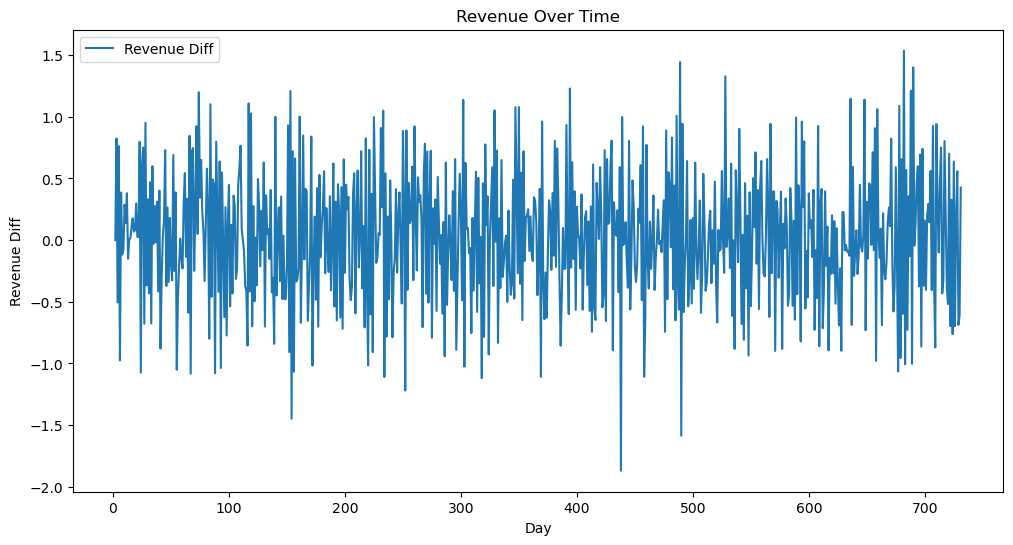

In [15]:
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue_Diff'], label='Revenue Diff')

# Adding a trendline
z = np.polyfit(df['Day'], df['Revenue_Diff'], 1)
p = np.poly1d(z)
# Adding labels and title
plt.xlabel('Day')
plt.ylabel('Revenue Diff')
plt.title('Revenue Over Time')
plt.legend()
plt.show()

<p>With stationarity established, we can proceed to split the data into test and training sets. Each of these datasets will be submitted alongside this Jupyter Notebook.</p>

In [16]:
# Selecting the relevant columns
df_subset = df[['Day', 'Revenue_Diff']]

# Splitting the data into training and testing sets
train, test = train_test_split(df_subset, test_size=0.2, random_state=42, shuffle=False)

print("Training Set:")
print(train.head())
print("\nTesting Set:")
print(test.head())

Training Set:
   Day  Revenue_Diff
0    1           NaN
1    2      0.000793
2    3      0.824749
3    4     -0.505210
4    5      0.762222

Testing Set:
     Day  Revenue_Diff
584  585      0.179940
585  586     -0.531923
586  587      0.157387
587  588     -0.644689
588  589      0.995057


<h5>Copy of Dataset</h5>
<p>The cleaned dataset will be provided alongside this submission. It will include the cleaned data immediately prior to the data split and immediately after.</p>

In [ ]:
train.to_csv('P1_train_cleaned.csv')
test.to_csv('P1_test_cleaned.csv')
df_subset.to_csv('P1_cleaned.csv')

<h4 id="D">Model Identification and Analysis</h4>
<h5>Reported Findings</h5>
